### Домашнее задание: Метод ближайших соседей

Учимся работе с данными - от загрузки до моделирования

Цель: В этом домашнем задании вам предстоит поработать с достаточно небольшим, но интересным датасетом по раку груди (https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data). Признаками в этом наборе данных являются различные измерения образований в груди, такие как радиус, симметричность и т.д. Целевая переменная — диагноз, является ли новообразование злокачественным или нет.


#### Часть 1. Анализ данных.

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mp
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc


sns.set_theme()

RANDOM_SEED = 42

Отобразим базовые признаки датасета.

In [6]:
data = pd.read_csv('data.csv', memory_map=True)
data.drop(columns=['Unnamed: 32'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Проверим отсутствующие значения (на всякий случай).

In [7]:
data.isna().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [8]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Построим визуализацию распределения диагнозов.

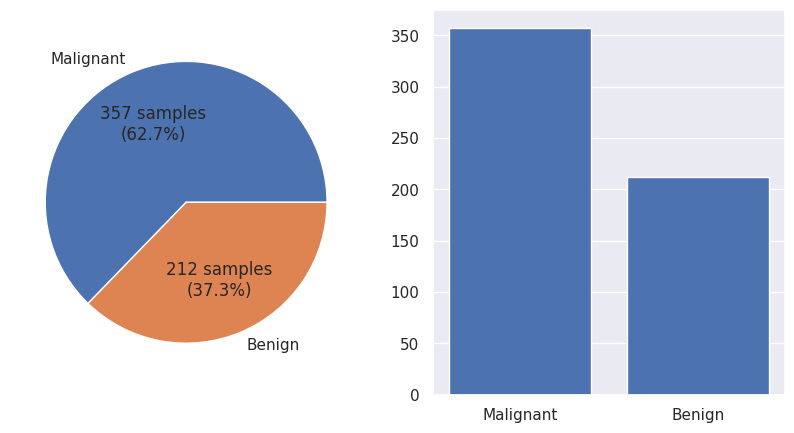

In [9]:
value_counts = data['diagnosis'].value_counts()
total = value_counts.values.sum()

fig, (axes_1, axes_2) = mp.pyplot.subplots(1, 2, figsize=(10,5))

axes_1.pie(
    value_counts,
    labels={'Malignant': 'M', 'Benign': 'B'},
    autopct=lambda x: '{:.0f} samples\n({:.1f}%)'.format(total*x/100, x)
)

axes_2.bar(
    data=value_counts,
    x=['Malignant', 'Benign'],
    height=value_counts
)
axes_2.grid(axis='x')

mp.pyplot.show()

Сгруппируем признаки в тройки по типу: среднее, стандартная ошибка, худшее значение.

Построим гистограммы распределения признаков, в зависимости от диагноза.

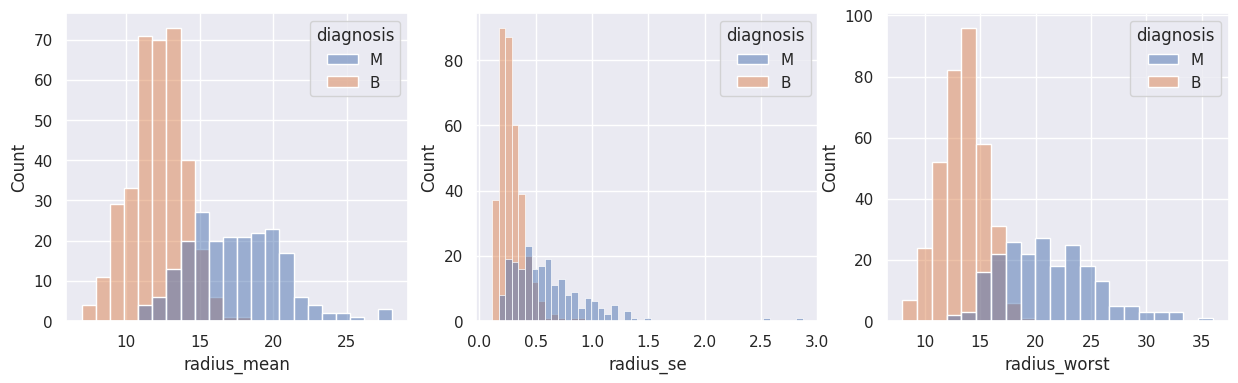

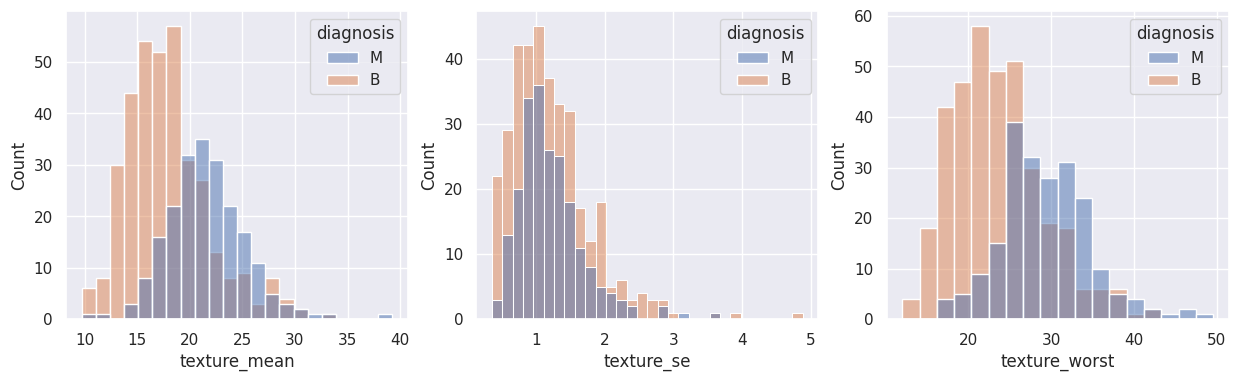

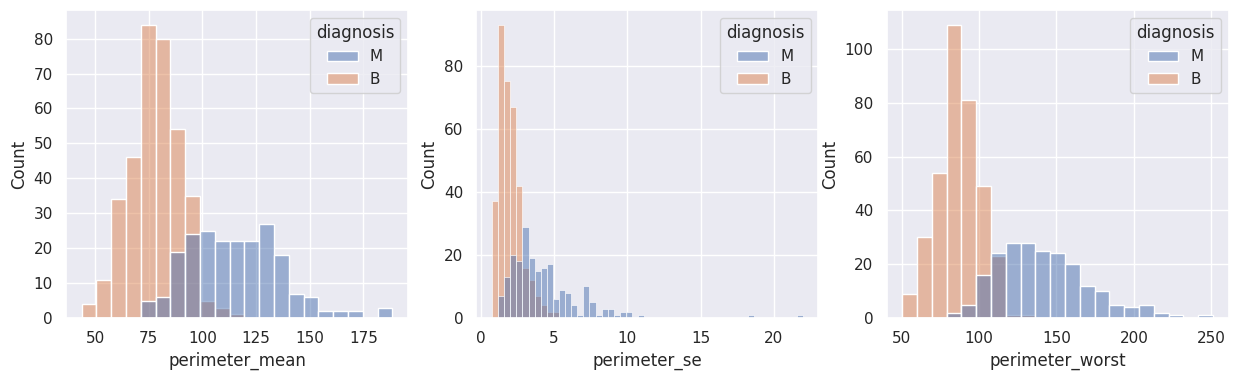

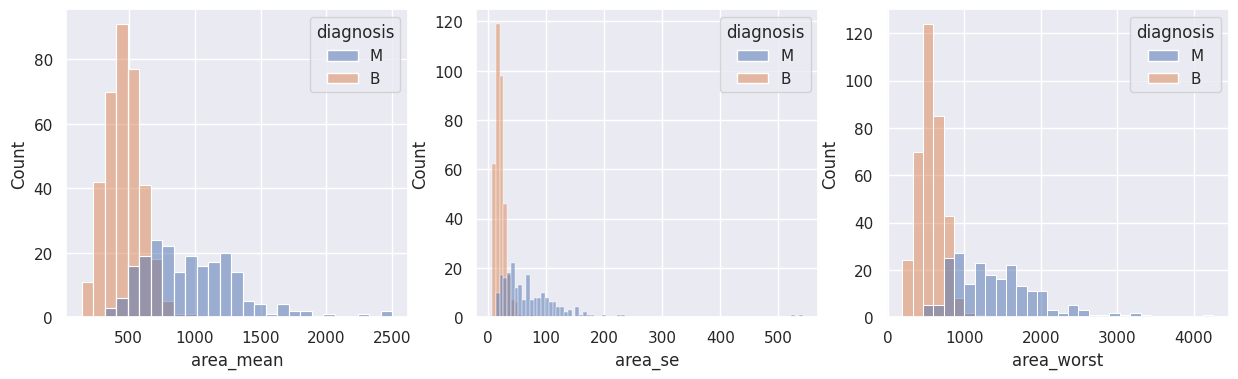

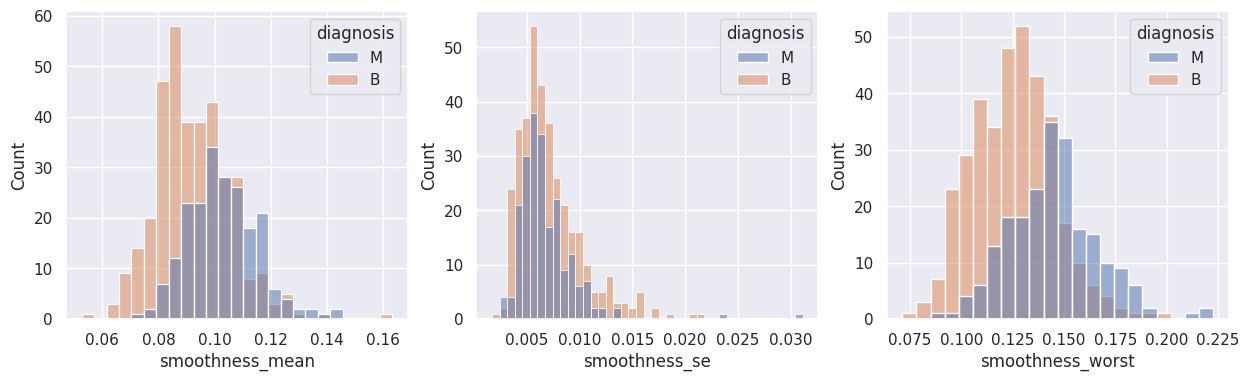

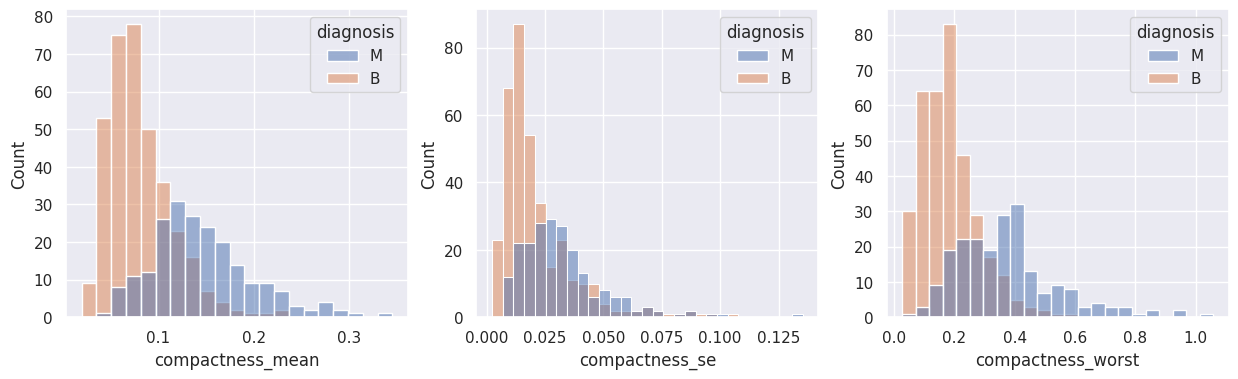

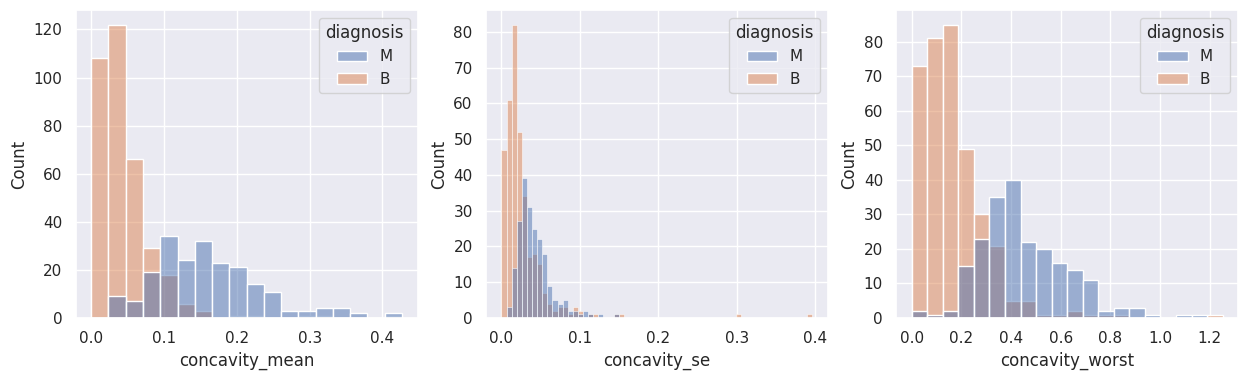

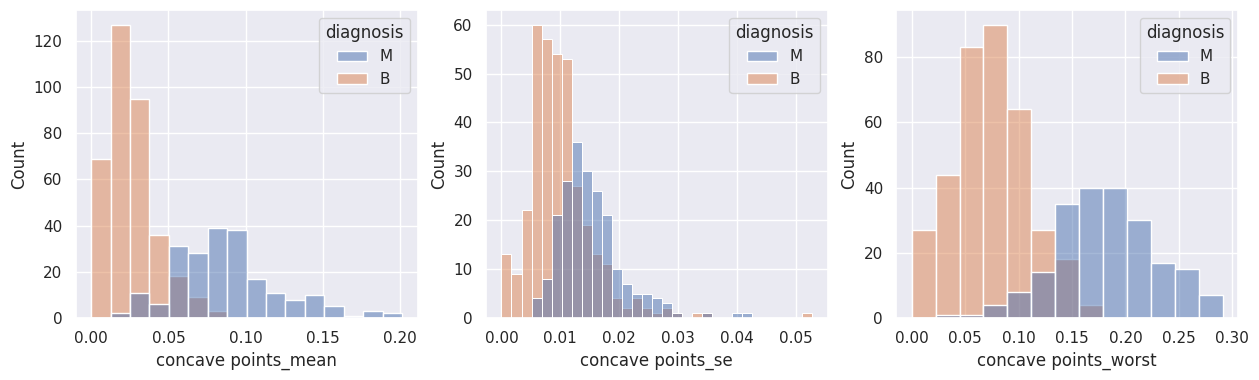

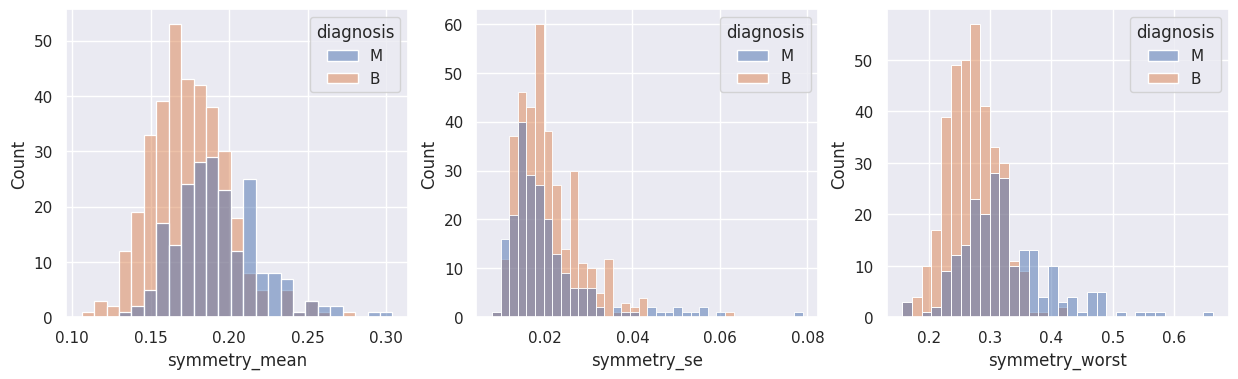

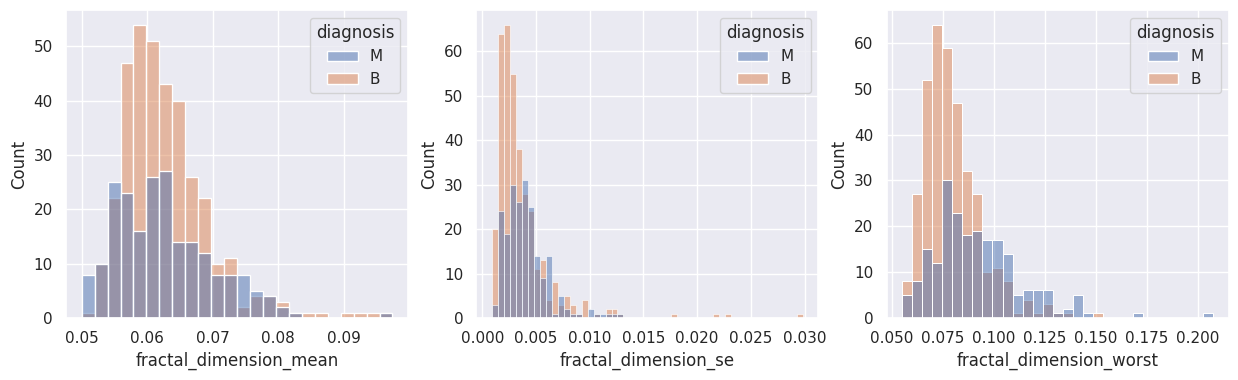

In [10]:
HIST_ROWS = [
    ('radius_mean', 'radius_se', 'radius_worst'),
    ('texture_mean', 'texture_se', 'texture_worst'),
    ('perimeter_mean', 'perimeter_se', 'perimeter_worst'),
    ('area_mean', 'area_se', 'area_worst'),
    ('smoothness_mean', 'smoothness_se', 'smoothness_worst'),
    ('compactness_mean', 'compactness_se', 'compactness_worst'),
    ('concavity_mean', 'concavity_se', 'concavity_worst'),
    ('concave points_mean', 'concave points_se', 'concave points_worst'),
    ('symmetry_mean', 'symmetry_se', 'symmetry_worst'),
    ('fractal_dimension_mean', 'fractal_dimension_se', 'fractal_dimension_worst')
]
for hist_row in HIST_ROWS:
    fig, (ax_0, ax_1, ax_2) = mp.pyplot.subplots(1, 3, figsize=(15,4))
    sns.histplot(data[['id', hist_row[0], 'diagnosis']], x=hist_row[0], hue='diagnosis', ax=ax_0)
    sns.histplot(data[['id', hist_row[1], 'diagnosis']], x=hist_row[1], hue='diagnosis', ax=ax_1)
    sns.histplot(data[['id', hist_row[2], 'diagnosis']], x=hist_row[2], hue='diagnosis', ax=ax_2)
    mp.pyplot.show()


Визуально, коррелируют между собой признаки:
* area -- compactness
* smoothness -- symmetry
* radius -- perimeter
* concavity -- concave points

Построим матрицу корреляций.

In [11]:
correlation_matrix = data.corr(numeric_only=True)
correlation_matrix

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,1.000000,0.074626,0.099770,0.073159,0.096893,-0.012968,0.000096,0.050080,0.044158,-0.022114,...,0.082405,0.064720,0.079986,0.107187,0.010338,-0.002968,0.023203,0.035174,-0.044224,-0.029866
radius_mean,0.074626,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.099770,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.073159,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.096893,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,-0.012968,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.000096,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.050080,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.044158,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,-0.022114,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413


Построим тепловую карту матрицы корреляций.

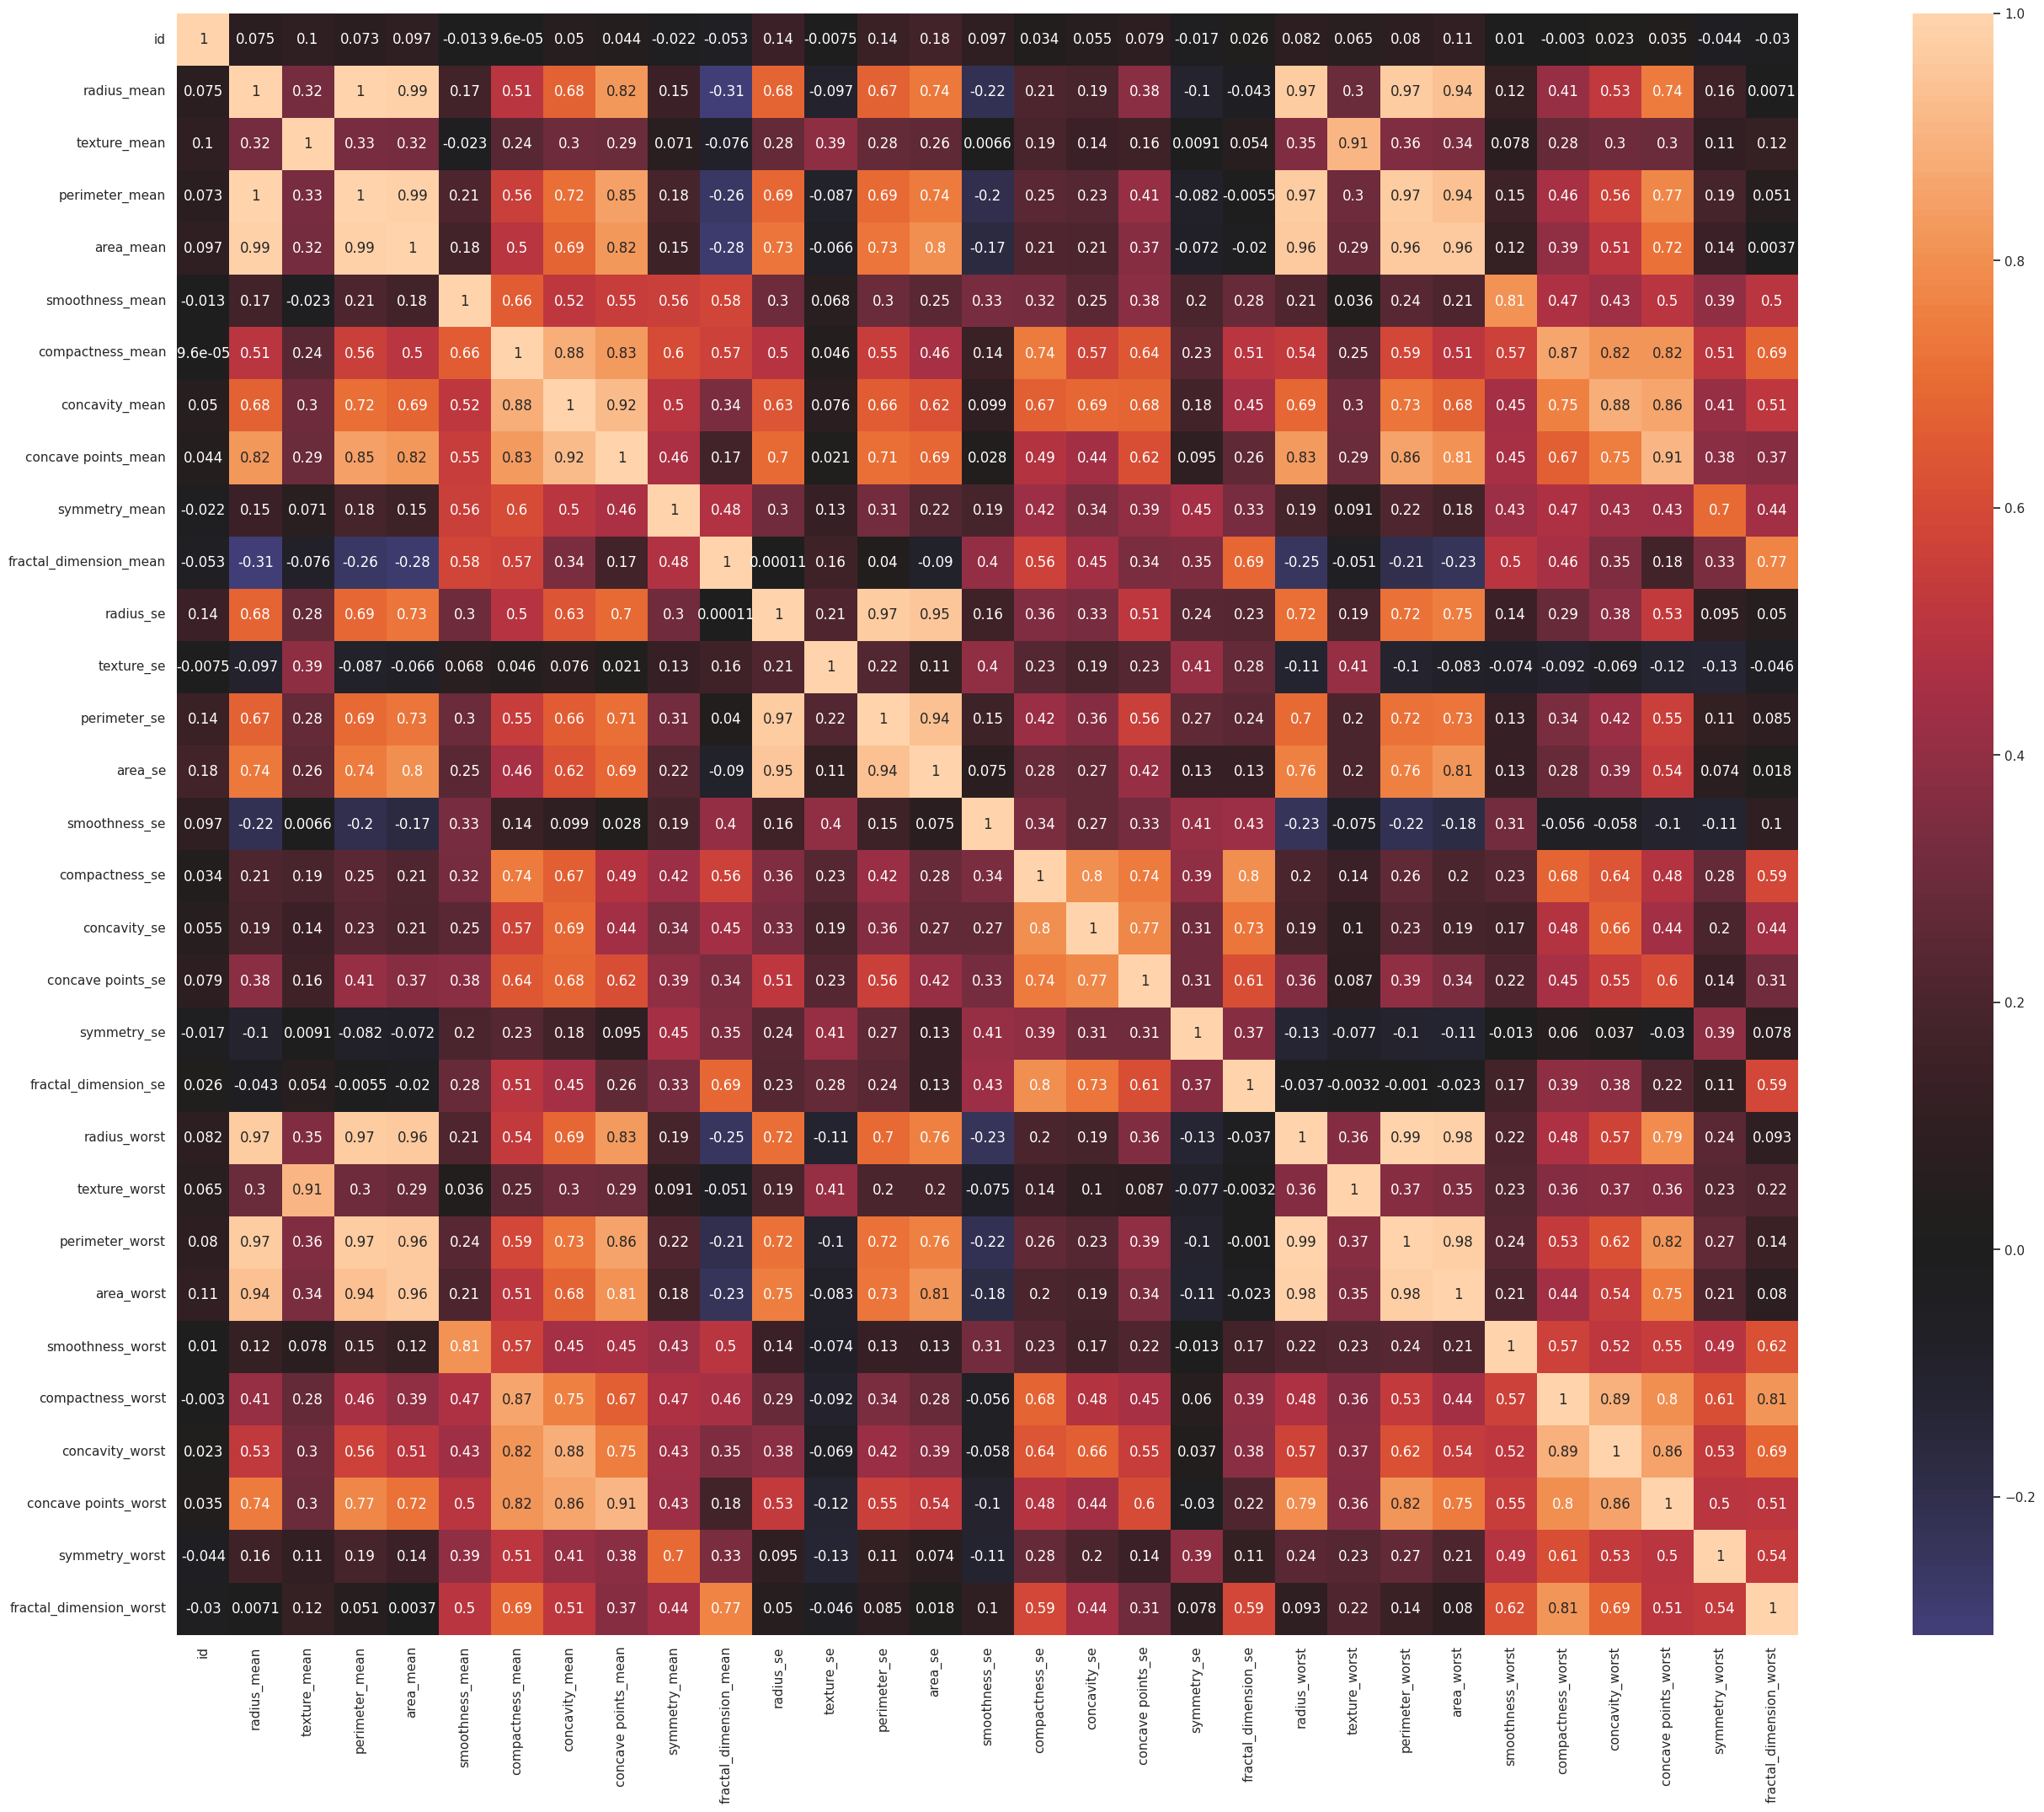

In [12]:
mp.pyplot.figure(figsize=(35, 25))
sns.heatmap(
    correlation_matrix, 
    annot=True,
    center=0,
    square=True
)
mp.pyplot.show()

Отберём сильно скоррелированные признаки (корреляция > 0.85).

In [13]:
corr_matrix = correlation_matrix.copy()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
correlation_pairs = corr_matrix.where(mask).stack().reset_index()
correlation_pairs.columns = ['feature_a', 'feature_b', 'correlation']
high_correlation_pairs = correlation_pairs[
    (correlation_pairs['correlation'].abs() > 0.85) & 
    (correlation_pairs['feature_a'] != correlation_pairs['feature_b'])
]
high_correlation_pairs = high_correlation_pairs.reindex(
    high_correlation_pairs['correlation'].abs().sort_values(ascending=False).index
)
high_correlation_pairs.reset_index(drop=True)

,feature_a,feature_b,correlation
0,radius_mean,perimeter_mean,0.997855
1,radius_worst,perimeter_worst,0.993708
2,radius_mean,area_mean,0.987357
3,perimeter_mean,area_mean,0.986507
4,radius_worst,area_worst,0.984015
5,perimeter_worst,area_worst,0.977578
6,radius_se,perimeter_se,0.972794
7,perimeter_mean,perimeter_worst,0.970387
8,radius_mean,radius_worst,0.969539
9,perimeter_mean,radius_worst,0.969476


Для сильно скоррелированных признаков построим попарные графики scatterplot.

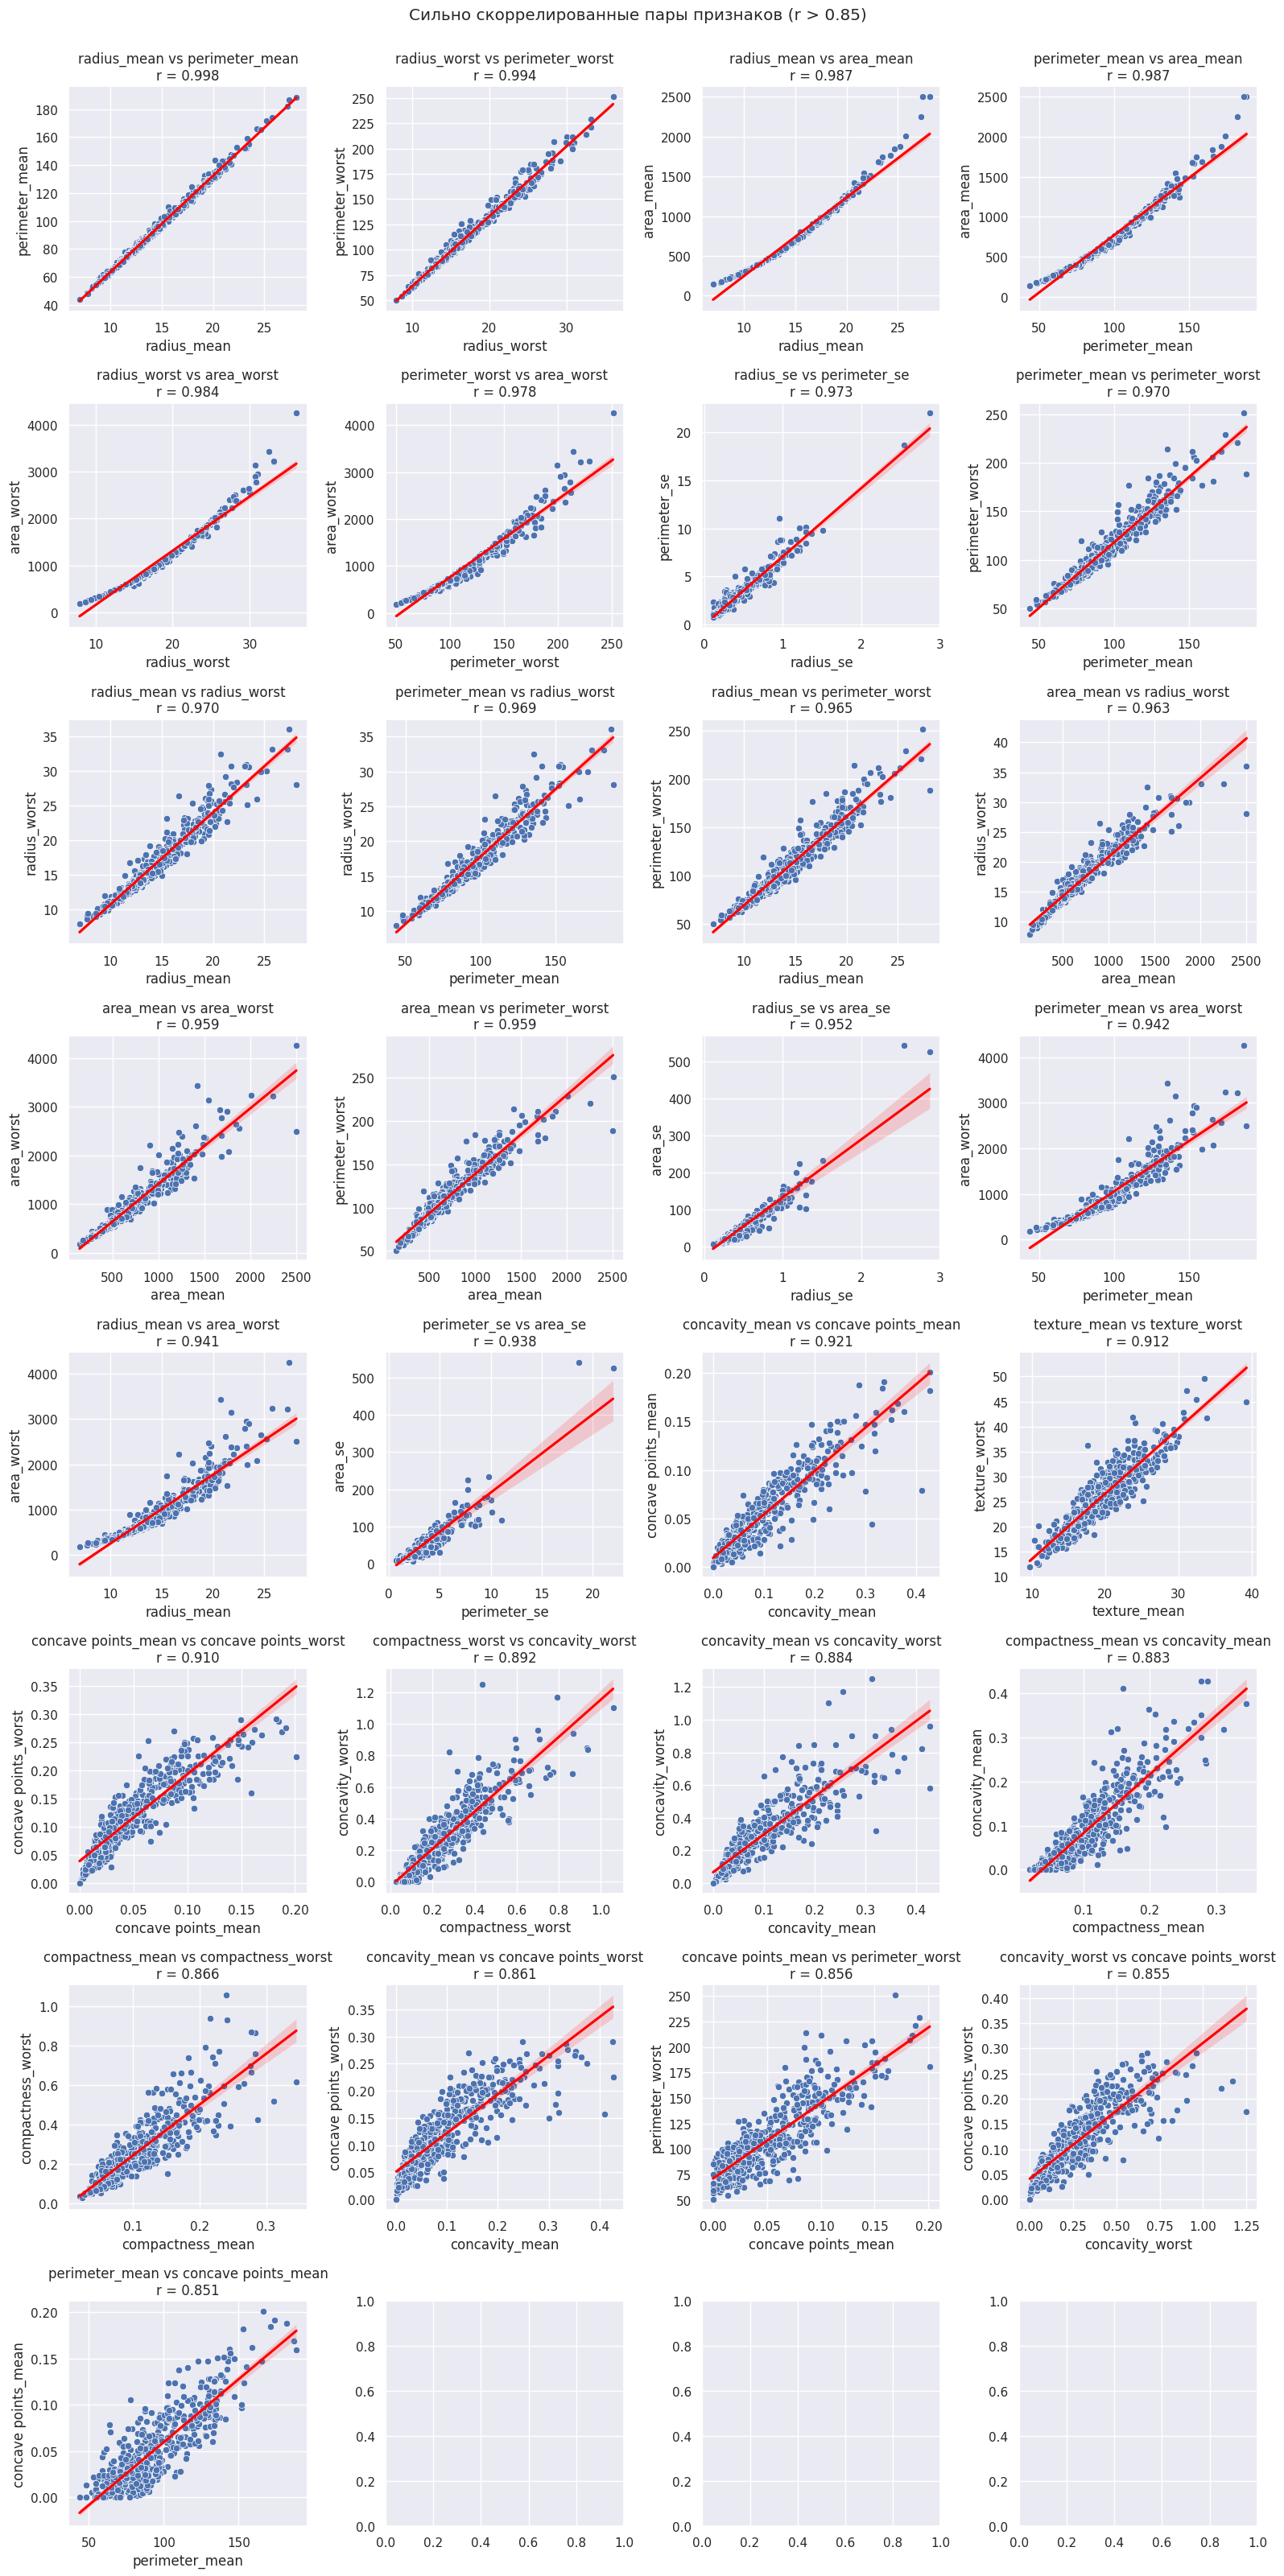

In [14]:
n_pairs = len(high_correlation_pairs)
n_cols = 4
n_rows = (n_pairs + n_cols - 1) // n_cols

fig, axes = mp.pyplot.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
fig.suptitle('Сильно скоррелированные пары признаков (r > 0.85)', y=1.0)

for idx, (_, row) in enumerate(high_correlation_pairs.iterrows()):
    feature_a, feature_b, correlation = row['feature_a'], row['feature_b'], row['correlation']
    
    row_idx = idx // n_cols
    col_idx = idx % n_cols
    
    ax = axes[row_idx, col_idx]
    sns.scatterplot(data=data, x=feature_a, y=feature_b, ax=ax)
    sns.regplot(data=data, x=feature_a, y=feature_b, ax=ax, scatter=False, line_kws={'color': 'red'})
    ax.set_title(f'{feature_a} vs {feature_b}\nr = {correlation:.3f}')

mp.pyplot.tight_layout()
mp.pyplot.show()

Судя по графикам выше, сильно скоррелированными признаками с линейной зависимостью можно считать первые 14 пар:
* radius_mean -- perimeter_mean
* radius_worst -- perimeter_worst
* radius_mean -- area_mean
* perimeter_mean -- area_mean
* radius_worst -- area_worst
* perimeter_worst -- area_worst
* radius_se -- perimeter_se
* perimeter_mean -- perimeter_worst
* radius_mean -- radius_worst
* perimeter_mean -- radius_worst
* radius_mean -- perimeter_worst
* area_mean -- radius_worst
* area_mean -- area_worst
* area_mean -- perimeter_worst

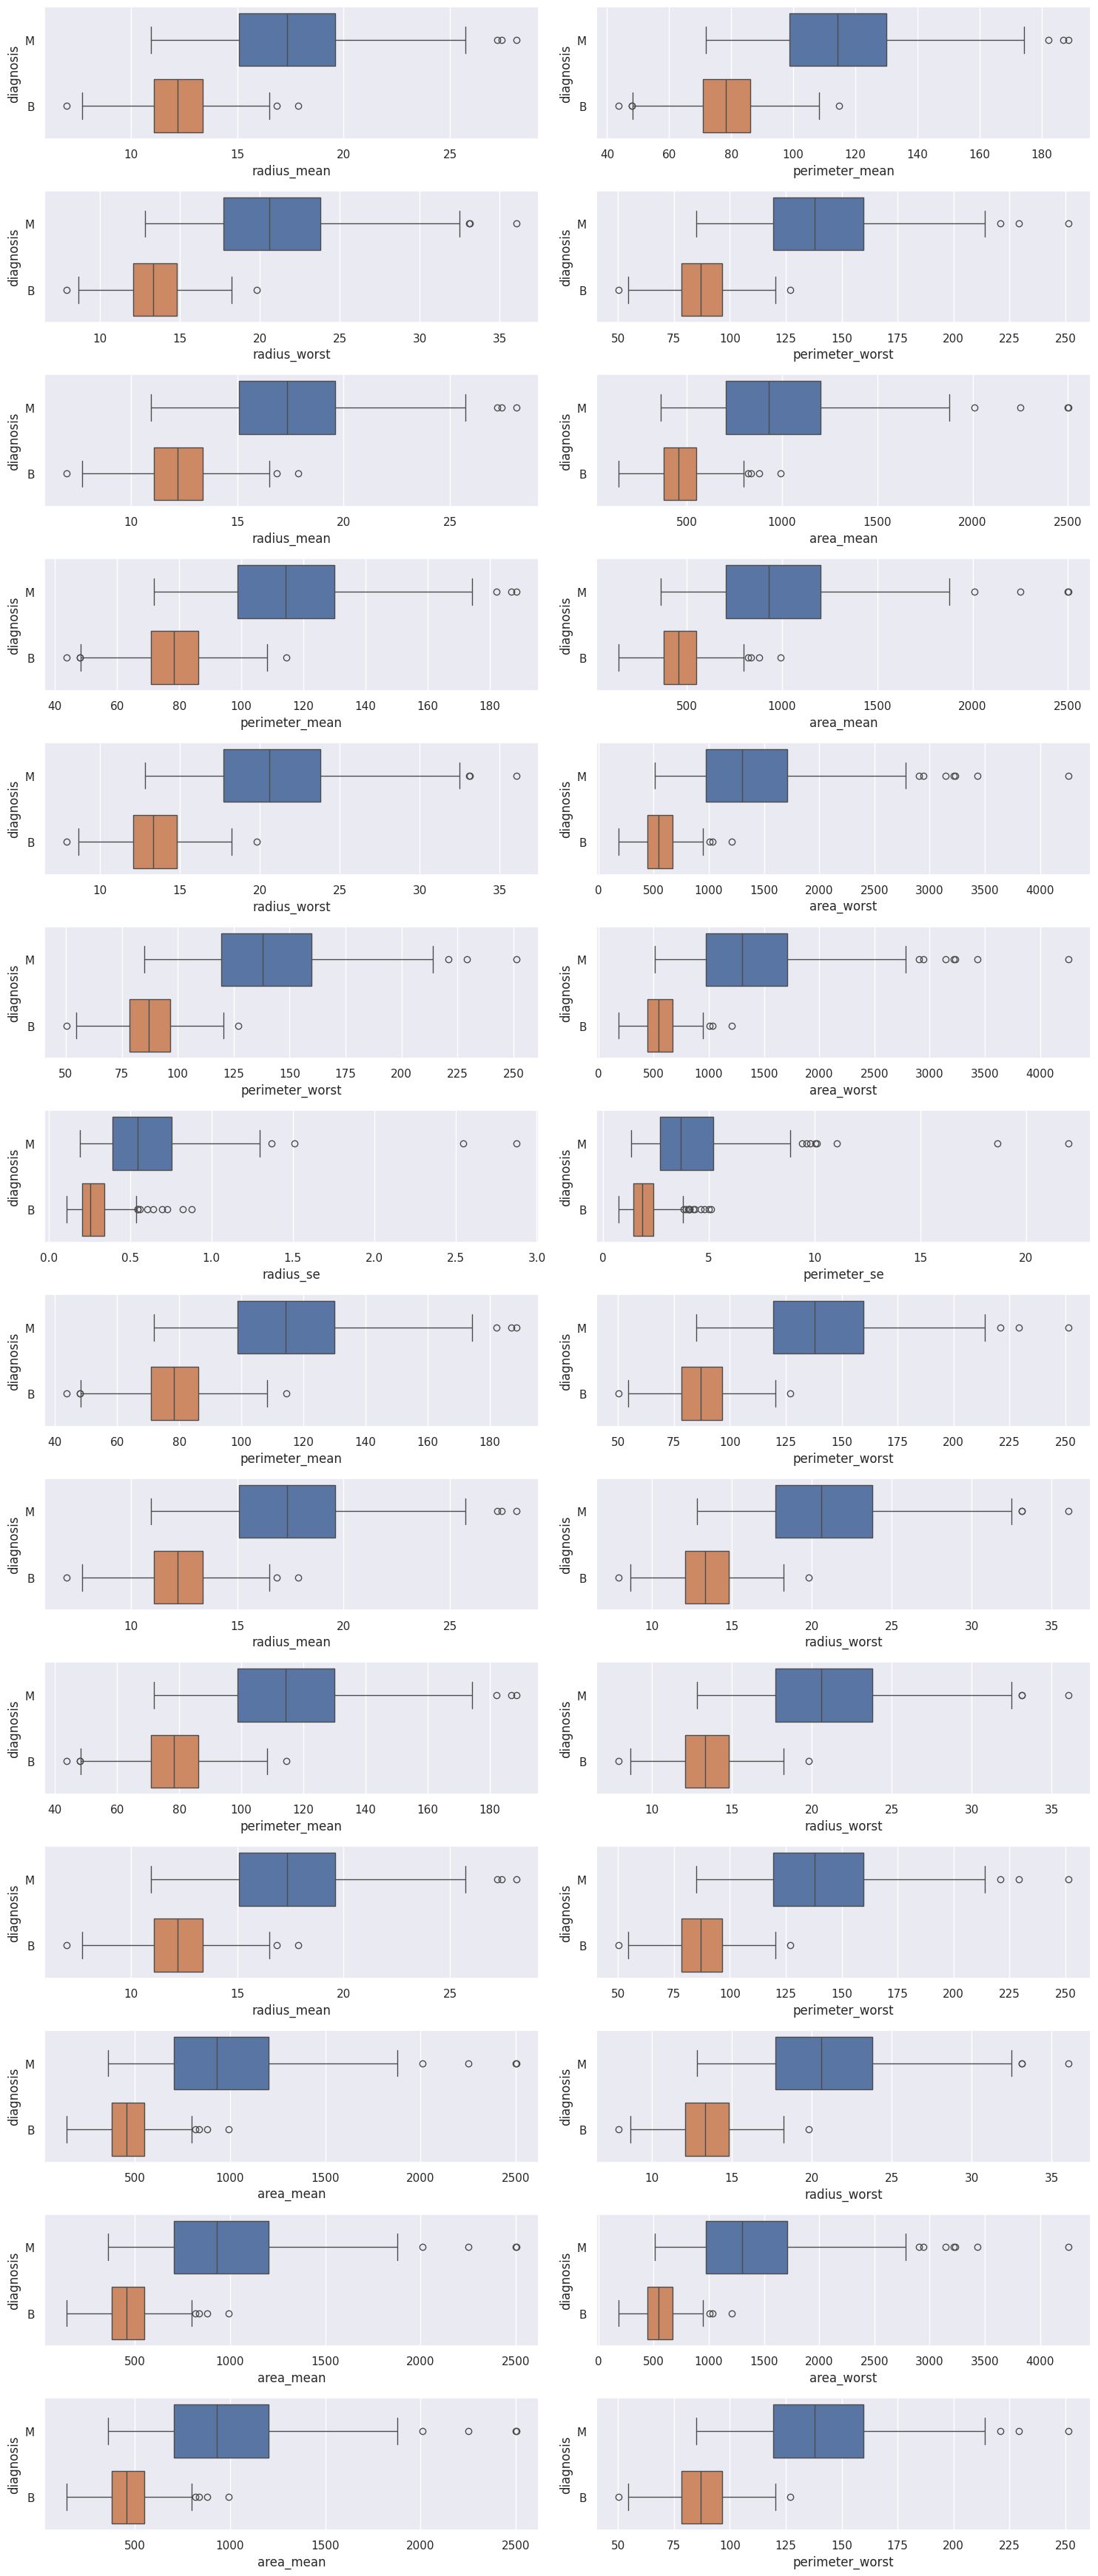

In [15]:
best_pairs = 14
fig, axes = mp.pyplot.subplots(best_pairs, 2, figsize=(15,35))

for idx, (_, row) in enumerate(high_correlation_pairs.iterrows()):
    if idx >= best_pairs:
        break;

    feature_a, feature_b, correlation = row['feature_a'], row['feature_b'], row['correlation']
    
    sns.boxplot(data=data, x=feature_a, y='diagnosis', hue='diagnosis', ax=axes[idx][0])
    sns.boxplot(data=data, x=feature_b, y='diagnosis', hue='diagnosis', ax=axes[idx][1])

mp.pyplot.tight_layout()
mp.pyplot.show()

Не понимаю, как можно выбрать признаки для отделения злокачественные новообразований от доброкачественных...

Могу только предположить, что надо откинуть вторые признаки из пар сильно скоррелированных признаков, и использовать оставшиеся признаки для предсказания доброкачественности/злокачественности.

#### Часть 2. Моделирование при помощи kNN.

In [16]:
X = data.drop(['id', 'diagnosis'], axis=1)
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 30), (171, 30), (398,), (171,))

Судя по результатам `data.describe()`, данные нуждаются в нормализации, т.к. есть "фичи" с диапазонами значений от 0...1 до нескольких тысяч. Разброс 4 порядка.

In [17]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [18]:
def quality(title, prediction_y, true_y):
    print(title)
    accuracy = accuracy_score(y_pred=prediction_y, y_true=true_y)
    precision = precision_score(y_pred=prediction_y, y_true=true_y, average='weighted')
    recall = recall_score(y_pred=prediction_y, y_true=true_y, average='weighted')
    f1 = f1_score(y_pred=prediction_y, y_true=true_y, average='weighted')
    print("Accuracy:  {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall:    {:.4f}".format(recall))
    print("F1-score:  {:.4f}".format(f1))
    print()
    

In [26]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
quality(f"X_test:predict(n_neighbors=3)", y_predict, y_test)

X_test:predict(n_neighbors=3)
Accuracy:  0.9591
Precision: 0.9590
Recall:    0.9591
F1-score:  0.9590



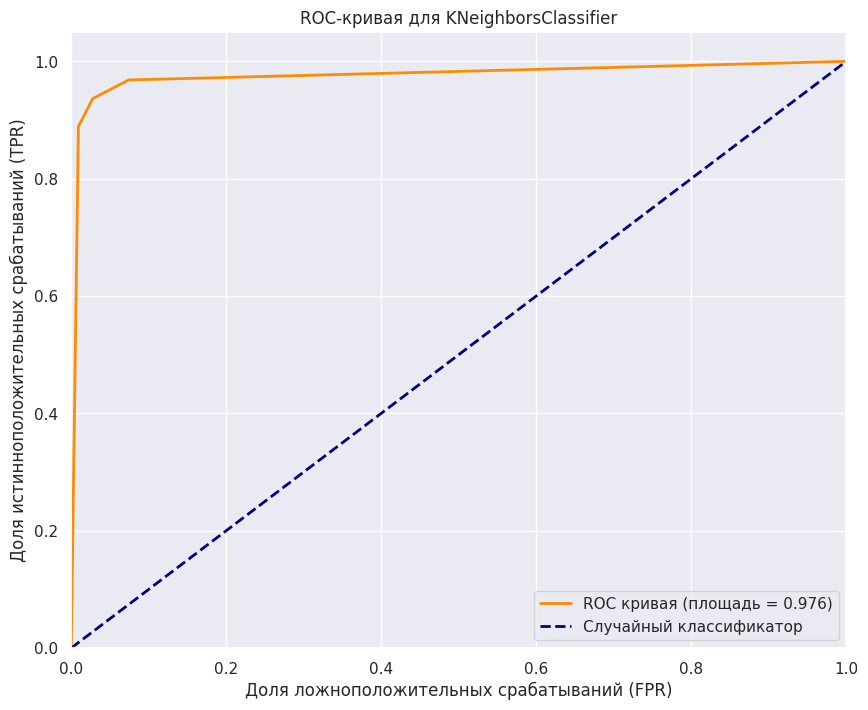

AUC-ROC (площадь): 0.976


In [20]:
def print_roc_auc(x, y):
    y_proba = knn.predict_proba(x)
    y_score = y_proba[:, 1]

    fpr, tpr, thresholds = roc_curve(y, y_score, pos_label='M')
    roc_auc = auc(fpr, tpr)

    mp.pyplot.figure(figsize=(10, 8))
    mp.pyplot.plot(fpr, tpr, color='darkorange', lw=2, label='ROC кривая (площадь = %0.3f)' % roc_auc)
    mp.pyplot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
    mp.pyplot.xlim([0.0, 1.0])
    mp.pyplot.ylim([0.0, 1.05])
    mp.pyplot.xlabel('Доля ложноположительных срабатываний (FPR)')
    mp.pyplot.ylabel('Доля истинноположительных срабатываний (TPR)')
    mp.pyplot.title('ROC-кривая для KNeighborsClassifier')
    mp.pyplot.legend(loc="lower right")
    mp.pyplot.grid(True)
    mp.pyplot.show()

    print(f'AUC-ROC (площадь): {roc_auc:.3f}')

print_roc_auc(X_test, y_test)

In [21]:
cv_scores = cross_val_score(neighbors.KNeighborsClassifier(), X_test, y_test, cv=5, scoring='roc_auc')
print(f"AUC-ROC (кросс-валидация): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

AUC-ROC (кросс-валидация): 0.981 ± 0.019


In [22]:
k_range = range(1, 30)
metric = 'roc_auc_ovr'
k_scores = []
for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_test, y_test, cv=5, scoring=metric)
    k_scores.append(scores.mean())

optimal_k = k_range[np.argmax(k_scores)]
max_score = max(k_scores)
print(f"Оптимальное k: {optimal_k}, {metric}: {max_score:.4f}")

Оптимальное k: 23, roc_auc_ovr: 0.9979


#### Подбор $k$ при помощи GridSearchCV

In [33]:
param_grid = {'n_neighbors': range(1, 30)}

knn = neighbors.KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
grid_search = GridSearchCV(
    knn, 
    param_grid, 
    cv=cv, 
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

optimal_k = grid_search.best_params_['n_neighbors']
print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.4f}")


Best params: {'n_neighbors': 19}
Best score: 0.9899


Проверим модель на оптимальном k

In [38]:
knn = neighbors.KNeighborsClassifier(n_neighbors=optimal_k)

knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
quality(f"X_test:predict(n_neighbors={optimal_k})", y_predict, y_test)

X_test:predict(n_neighbors=19)
Accuracy:  0.9474
Precision: 0.9482
Recall:    0.9474
F1-score:  0.9469



С подбором при помощи `GridSearchCV` стало получше.